# monai 알아보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import os

print(os.getcwd())

/home/kunsu/Work/medical/medical


In [2]:
import monai
from monai.apps import DecathlonDataset, download_and_extract
from monai.data import DataLoader, Dataset
from monai.transforms import (
    EnsureChannelFirstd,  ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged,  ## nifiti, dicom image 읽어오기
    Spacingd,  ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd,  ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged,  # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf,  ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd,  ## Foreground부분만 남기는 방법
    Rand3DElasticd,  ## 3D 모양으로 Elastic Transform
    RandAffined,  ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated,  ## random roatate
    RandFlipd,
)
import tempfile
from monai.visualize.utils import blend_images, matshow3d  ## label과 Image를 합친 영상  ## 3d image의 visulization
import matplotlib.pyplot as plt

2025-05-11 12:05:52.473018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 12:05:52.756155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746932752.849315   50226 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746932752.878068   50226 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746932753.105987   50226 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# 3d 이미지 다운로드 하기
download = True
if download:
    directory = os.environ.get("MONAI_DATA_DIRECTORY")
    root_dir = tempfile.mkdtemp() if directory is None else directory
    print(f"root dir is: {root_dir}")

    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar"
    #     md5 = "8afd997733c7fc0432f71255ba4e52dc"

    compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
    data_dir = os.path.join(root_dir, "Task02_Heart")
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, root_dir)

root dir is: /tmp/tmpxp7sz5xr


Task02_Heart.tar: 435MB [00:26, 16.9MB/s]                              

2025-05-11 12:06:34,663 - INFO - Downloaded: /tmp/tmpxp7sz5xr/Task02_Heart.tar
2025-05-11 12:06:34,663 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpxp7sz5xr/Task02_Heart.tar.
2025-05-11 12:06:34,664 - INFO - Writing into directory: /tmp/tmpxp7sz5xr.


In [5]:
!ls /tmp/tmpxp7sz5xr/Task02_Heart/imagesTr

la_003.nii.gz  la_009.nii.gz  la_016.nii.gz  la_020.nii.gz  la_024.nii.gz
la_004.nii.gz  la_010.nii.gz  la_017.nii.gz  la_021.nii.gz  la_026.nii.gz
la_005.nii.gz  la_011.nii.gz  la_018.nii.gz  la_022.nii.gz  la_029.nii.gz
la_007.nii.gz  la_014.nii.gz  la_019.nii.gz  la_023.nii.gz  la_030.nii.gz


In [6]:
train_images = list((Path(data_dir) / "imagesTr").glob("*.nii.gz"))
train_labels = list((Path(data_dir) / "labelsTr").glob("*.nii.gz"))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': PosixPath('/tmp/tmpxp7sz5xr/Task02_Heart/imagesTr/la_014.nii.gz'),
 'label': PosixPath('/tmp/tmpxp7sz5xr/Task02_Heart/labelsTr/la_014.nii.gz')}

# 이미지 읽기

image shape: torch.Size([1, 320, 320, 120])
label shape: torch.Size([1, 320, 320, 110])
pixel spacing: tensor([1.2500, 1.2500, 1.3700], dtype=torch.float64)


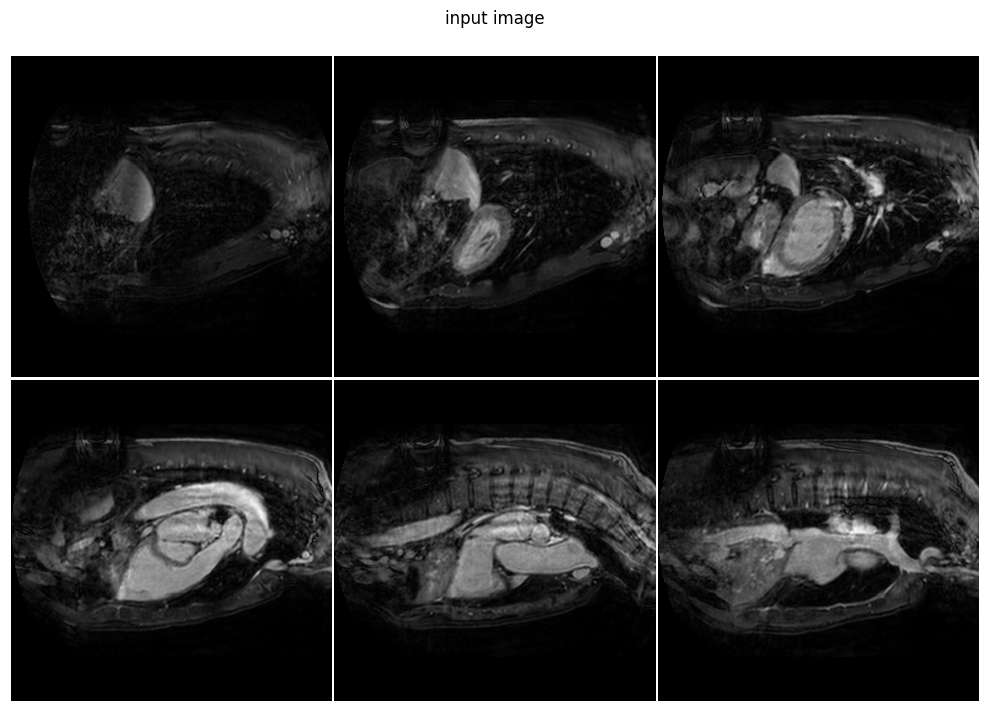

In [7]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
    ]
)
dataset = Dataset(data=val_data_dicts, transform=transform)

print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [8]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(2, 2, 3), mode=("bilinear", "nearest")),
    ]
)
dataset = Dataset(data=val_data_dicts, transform=transform)

image의 scale을 spacing에 따라 resampling을 함으로써 작은 object에 크게 학습 가능해짐

image shape: torch.Size([1, 200, 200, 55])
label shape: torch.Size([1, 200, 200, 51])
pixel spacing: tensor([2., 2., 3.], dtype=torch.float64)


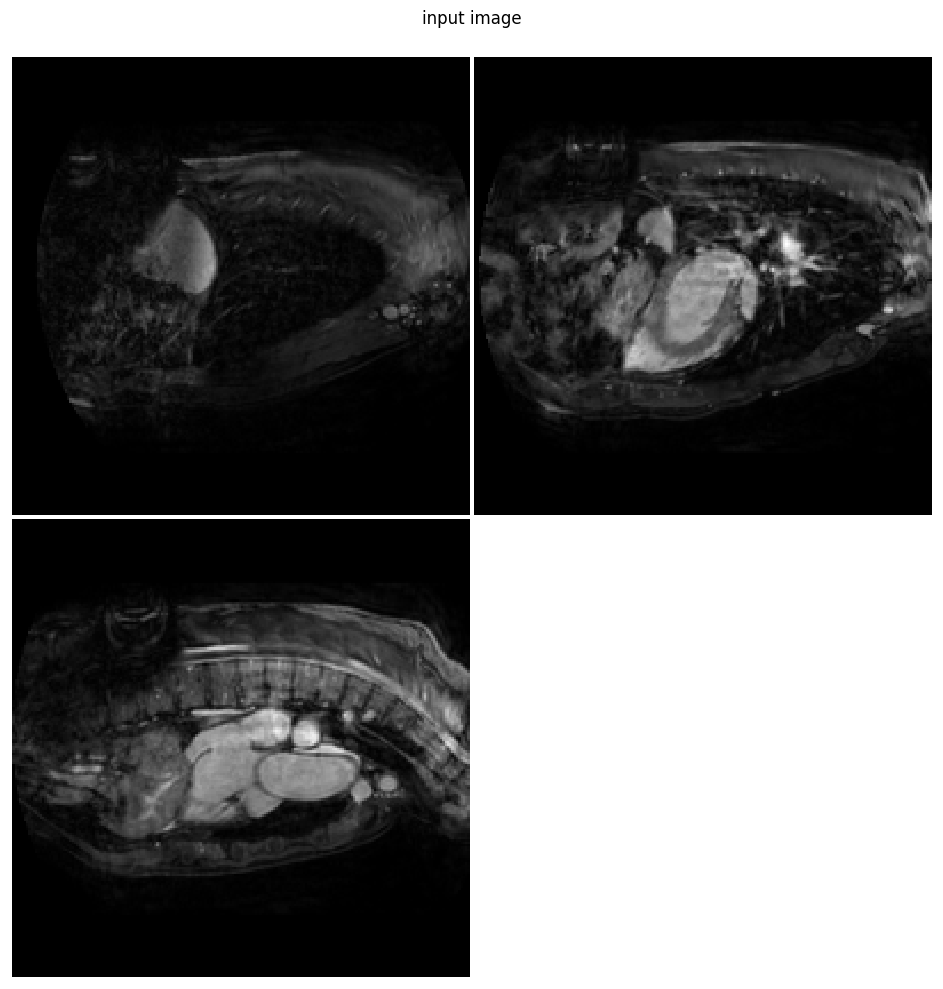

In [9]:
print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

Foreground영역의 분할을 할경우 background의 noised영역이 제거 됨으로 cost가 줄어든다

/home/kunsu/miniconda3/envs/fast/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


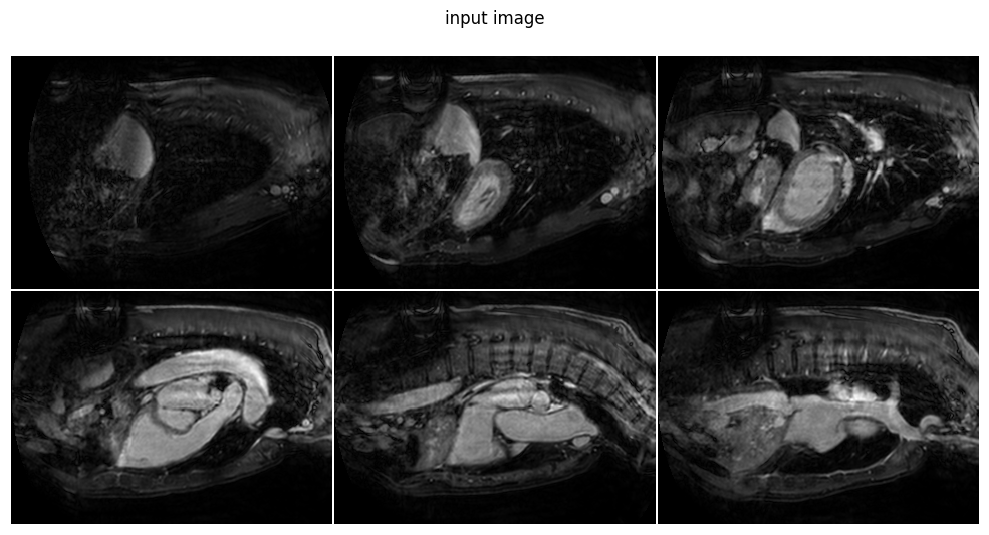

In [10]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #         NormalizeIntensityd(keys=["image"])
    ]
)

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [11]:
dataset[0]["image"].max()

metatensor(1888.)

In [12]:
from monai.transforms import NormalizeIntensityd

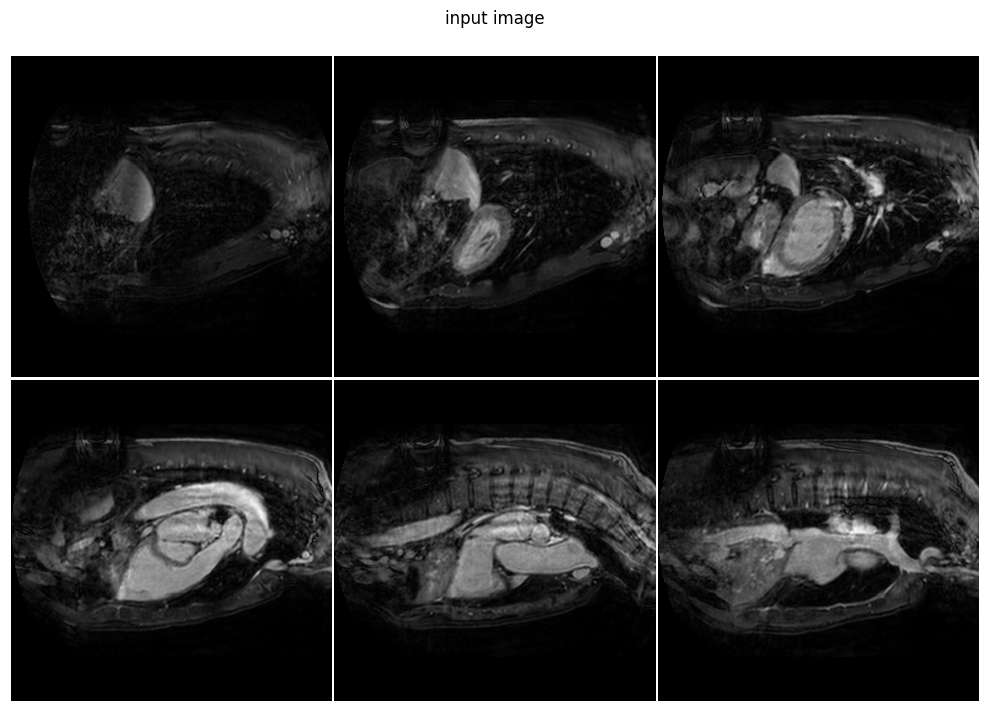

In [13]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(keys="image", channel_wise=True),
    ]
)

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [14]:
from monai.transforms import (
    EnsureChannelFirstd,  ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged,  ## nifiti, dicom image 읽어오기
    Spacingd,  ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd,  ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged,  # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf,  ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd,  ## Foreground부분만 남기는 방법
    Rand3DElasticd,  ## 3D 모양으로 Elastic Transform
    RandAffined,  ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated,  ## random roatate
    RandFlip,
    RandRotate90d,
)

In [15]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=1,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=1,
            max_k=3,
        ),
    ]
)

dataset = Dataset(data=val_data_dicts, transform=transform)

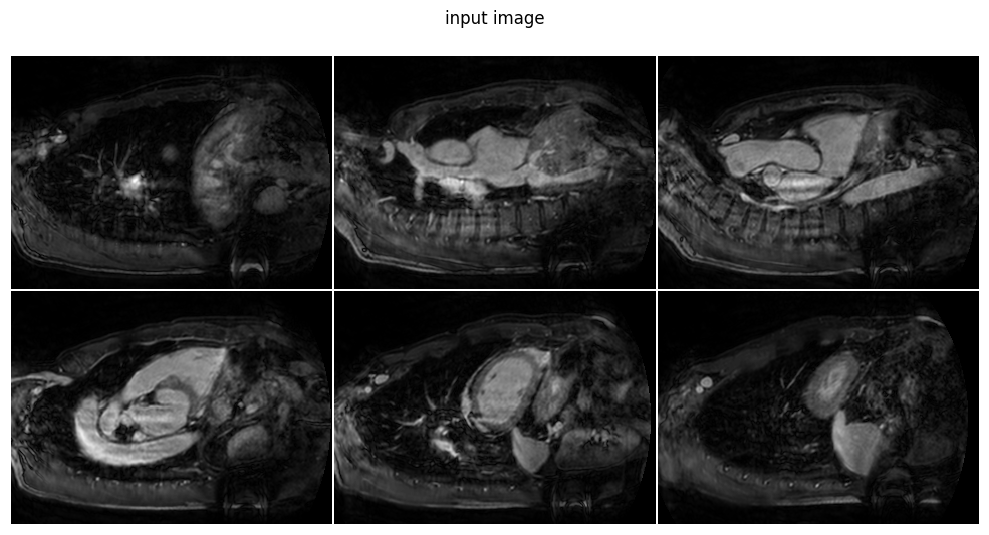

In [16]:
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

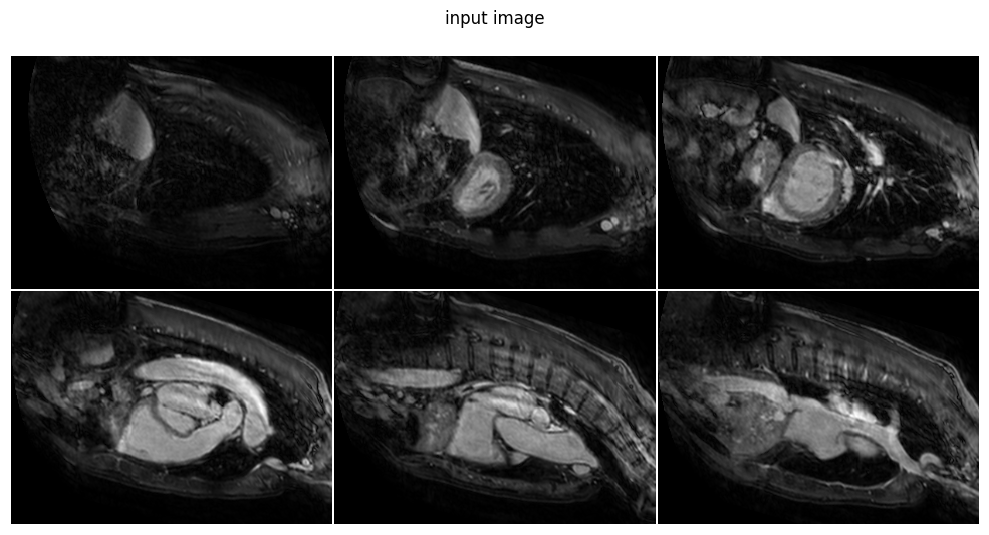

In [17]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined(
            keys=["image", "label"],
            shear_range=(0.5, 0.5),
            mode="bilinear",
            padding_mode="zeros",
            prob=1,
        ),
    ]
)

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

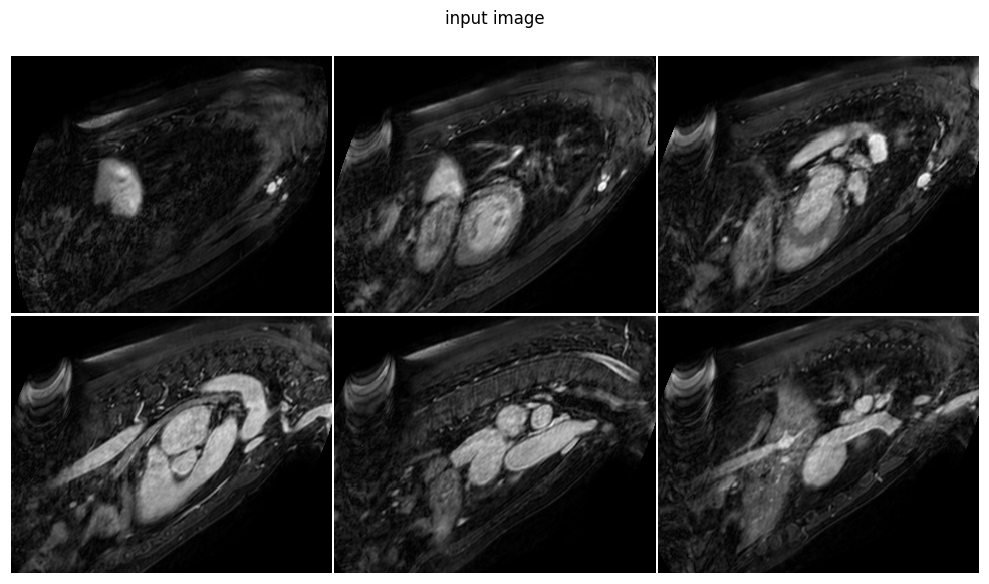

In [18]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined(
            keys=["image", "label"],
            shear_range=(0.5, 0.5),
            mode="bilinear",
            padding_mode="zeros",
            prob=1,
        ),
    ]
)

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

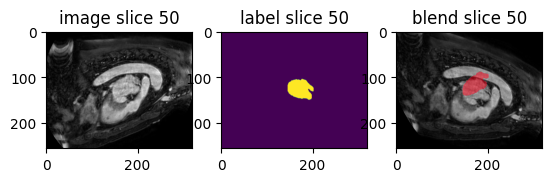

In [19]:
import torch
import matplotlib.pyplot as plt

ret = blend_images(image=dataset[0]["image"], label=dataset[0]["label"], alpha=0.5, cmap="hsv", rescale_arrays=True)
fig, axs = plt.subplots(1, 3)
# plot the slice 50 - 100 of image, label and blend result
slice_index = 10 * 5
axs[0].set_title(f"image slice {slice_index}")
axs[0].imshow(dataset[0]["image"][0, :, :, slice_index], cmap="gray")
axs[1].set_title(f"label slice {slice_index}")
axs[1].imshow(dataset[0]["label"][0, :, :, slice_index])
axs[2].set_title(f"blend slice {slice_index}")
axs[2].imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))

In [20]:
### hard augmenation
from monai.transforms import (
    RandKSpaceSpikeNoised,  ## 주파수 영역의 이미지에서 noise를 추가하여준다 .
    AdjustContrastd,  ## 영상의 밝기 조절
    GaussianSmoothd,  ## 이미지에 Gaussian을 적용하여 smooth하게 만듬
    RandCoarseDropoutd,  ## Cutout처럼 이미지에 특정영역에 box를 적용
    HistogramNormalized,  ## 이미지의 histogram을 normalize함으로써 영상의 밝기 향상
)

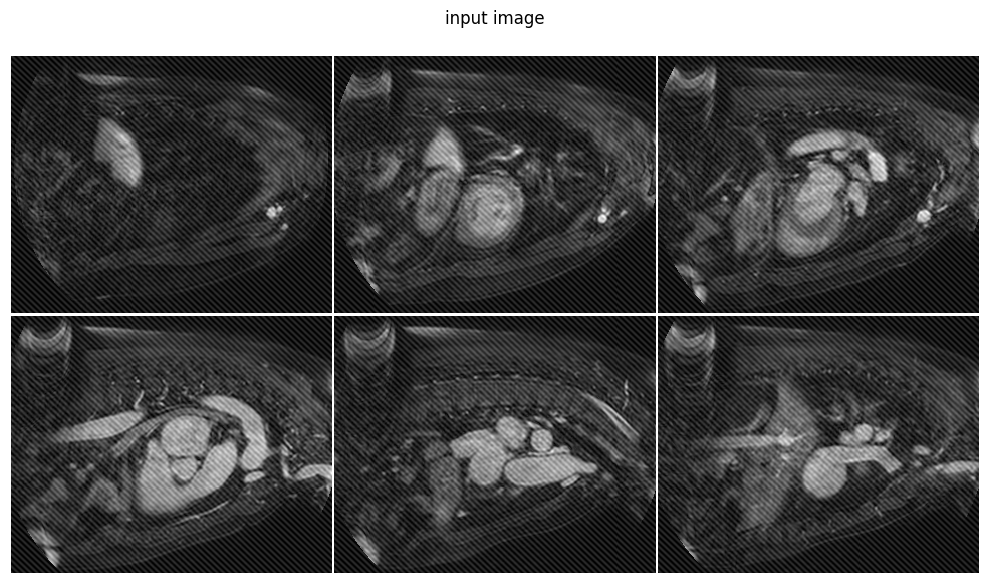

In [21]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandKSpaceSpikeNoised(keys=["image"], prob=1, intensity_range=(13, 15), channel_wise=True),
    ]
)

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

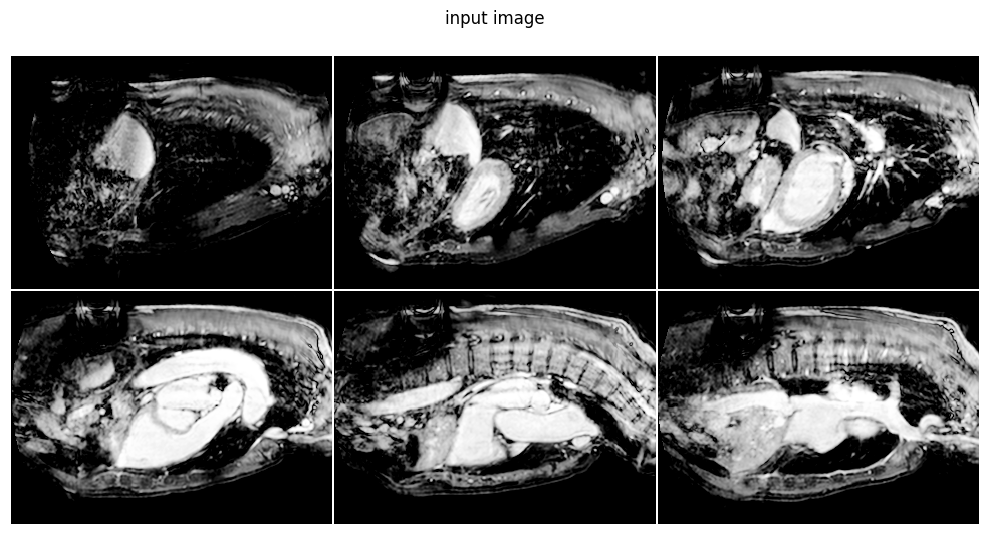

In [22]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        HistogramNormalized(keys=["image"], num_bins=10),
    ]
)

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][..., 1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [23]:
import torchio as tio

# transform = tio.RandomAffine(scales=(1.2, 1.2), degrees=30, translation=10)

In [24]:
colin = tio.datasets.Colin27()
transforms_dict = {
    tio.RandomAffine(): 0.75,
    tio.RandomElasticDeformation(): 0.25,
}  # Using 3 and 1 as probabilities would have the same effect
transform = tio.OneOf(transforms_dict)

transformed = transform(colin)

24256512it [00:20, 1187798.61it/s]                              


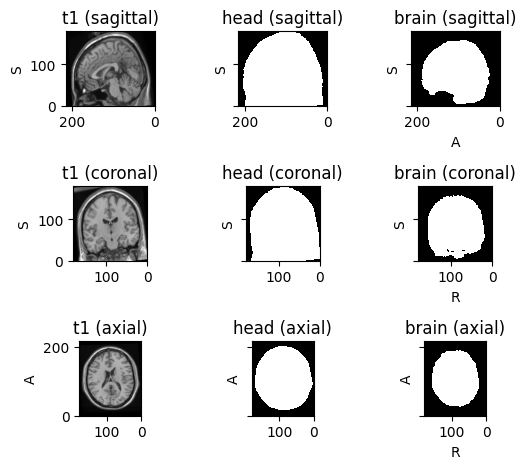

In [25]:
transformed.plot()

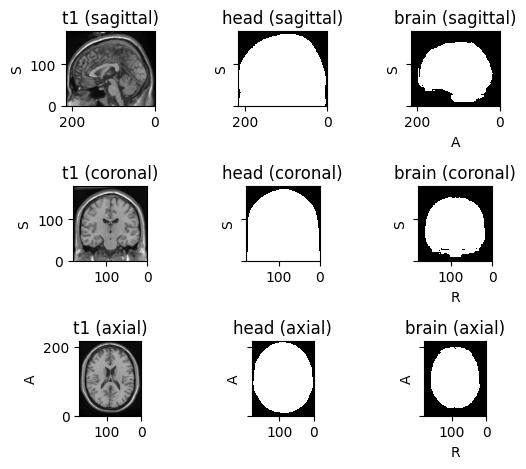

In [26]:
colin.plot()

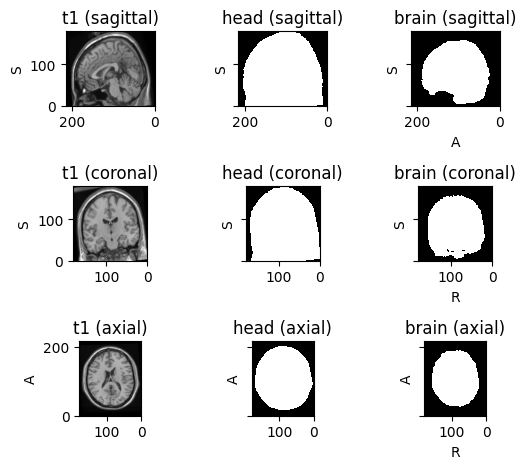

In [27]:
transformed.plot()